Compare results from fitting *the same mock galaxy* with data of different quality (i.e., S/N of the rest-frame optical spectroscopy)

Mock galaxy with Prospector fits are:
- constant SFR until quenched 4 Gyr ago
- constant SFR until quenched 10 Gyr ago


In [4]:
# imports 

import matplotlib.pyplot as plt
%matplotlib inline

import os
path_base = os.getcwd().split('Dragonfly44_SFH')[0] # hack, but works

import numpy as np

from copy import deepcopy

from Dragonfly44_SFH.utils.styles import *

In [5]:
showpars = ['mwa','t50','t90','logzsol','dust2']# 
showpar_labels = [ parameter_labels_with_units[p] for p in showpars ]

parameter_bounds['dust2'] = [-0.05,4]
showpar_bounds = [ parameter_bounds[p] for p in showpars ]


In [1]:

from Dragonfly44_SFH.utils import transforms
def get_posts( result, showpars, **extras ):
    from Dragonfly44_SFH.utils import transforms
    from dynesty.utils import resample_equal

    posts = []
    for par in showpars:

        if par in result['theta_index'].keys():
            x = transforms.chain_to_param( param=par, **result )

        elif par.startswith('t'):
            try:
                qt = float( par[1:] )/100.
                x = transforms.chain_to_quantiles( cmf_quantiles=[qt], **result)
            except:
                pass
        else:
            print('Dont know what to do with {}'.format(par))
            x = np.full_like( result['chain'][:,0], np.nan )


        x = np.squeeze(x)
        posts.append(x)

    wposts = resample_equal( np.stack(posts).T, result['weights'] )
    
    return wposts

def make_results( result_file, showpars=[], ddict=None, ddict_key=None, verbose=True, file_data=None, sfh=3, **extras ):
    from Dragonfly44_SFH.utils.prospect_io import read_results

    if not os.path.exists( result_file ):
        print( "Cannot read {}, file does not exist".format( result_file ))
    result,obs,model = read_results( result_file, file_data=file_data, sfh=sfh )
    
    if ddict is None: 
        ddict = dict( result=result, obs=obs, model=model )
        
    ddict['result_file'] = result_file
    if 'posts' not in ddict.keys(): ddict['posts'] = {}
        
    wposts = get_posts( result, showpars )
    for par,wp in zip( showpars, wposts.T ):
        ddict['posts'][par] = wp
            
    if obs['spectrum'] is not None:
         snr_spec = ( obs['spectrum']/obs['unc'] )[obs['mask']]
    else: snr_spec = [np.nan]
    ddict['snr'] = snr_spec
#     np.median( snr_spec )    

    return ddict


In [2]:
# truths, as calculated in Dragonfly44/data/mock_data/make_mock_galaxy_with_same_obs_as_DF44.ipynb
truths = { 'quench4GyrAgo':{}, 'quench10GyrAgo':{} }

for key in truths.keys():
    truths[key]['logzsol'] = -1.2
    truths[key]['dust2'] = 0

truths['quench4GyrAgo']['t50'] = 4.73566424942371
truths['quench4GyrAgo']['t90'] = 8.524195648962678
truths['quench4GyrAgo']['mwa'] = 8.717947176655137

truths['quench10GyrAgo']['t50'] = 1.73566424942371
truths['quench10GyrAgo']['t90'] = 3.124195648962678
truths['quench10GyrAgo']['mwa'] = 11.7127637030917



In [6]:
from Dragonfly44_SFH.fitting.output.fits_mocks_summary import *
path_fits = path_base+ "Dragonfly44_SFH/fitting/output/"
path_data = path_base+ "Dragonfly44_SFH/data/"


sfh_key = 'aD1'
sfh_label = sfh_labels[sfh_key]

# it's okay that the model will fail to load
# we don't need it here
# if it is needed, provide file_data 
# (done for the photometry fit, so that can calculate prior draws from model)

fits = { 'quench4GyrAgo':{}, 'quench10GyrAgo':{} }


file_data = path_data + 'mock_data/mock_obs_quench_4GyrAgo.h5'

fits['quench4GyrAgo'] = {'spec':{}, 'phot':{}, 'both':{} }

fits['quench4GyrAgo']['phot'] = make_results( path_fits+ fit_mock_quench4GyrAgo_aD1_phot, showpars, file_data=file_data )

fits['quench4GyrAgo']['both']['snr5']  = make_results( path_fits+ fit_mock_quench4GyrAgo_aD1_phot_specKCWI_snr5, showpars )
fits['quench4GyrAgo']['both']['snr10'] = make_results( path_fits+ fit_mock_quench4GyrAgo_aD1_phot_specKCWI_snr15, showpars )
fits['quench4GyrAgo']['both']['snr15'] = make_results( path_fits+ fit_mock_quench4GyrAgo_aD1_phot_specKCWI_snr25, showpars )
fits['quench4GyrAgo']['both']['snr20'] = make_results( path_fits+ fit_mock_quench4GyrAgo_aD1_phot_specKCWI_snr35, showpars )

fits['quench4GyrAgo']['spec']['snr5'] = None
fits['quench4GyrAgo']['spec']['snr10'] = None
fits['quench4GyrAgo']['spec']['snr15'] = None
fits['quench4GyrAgo']['spec']['snr20'] = None


fits['quench10GyrAgo'] = {'spec':{}, 'phot':{}, 'both':{} }

file_data = path_data + 'mock_data/mock_obs_quench_10GyrAgo.h5'

fits['quench10GyrAgo']['phot'] = make_results( path_fits+ fit_mock_quench10GyrAgo_aD1_phot, showpars, file_data=file_data )

fits['quench10GyrAgo']['both']['snr5'] = make_results( path_fits+ fit_mock_quench10GyrAgo_aD1_phot_specKCWI_snr5, showpars )
fits['quench10GyrAgo']['both']['snr15'] = make_results( path_fits+ fit_mock_quench10GyrAgo_aD1_phot_specKCWI_snr25, showpars )

fits['quench10GyrAgo']['spec']['snr5'] = None
fits['quench10GyrAgo']['spec']['snr15'] = None


Error: failed to produce model
Error: failed to produce model
Error: failed to produce model
Error: failed to produce model
Error: failed to produce model
Error: failed to produce model


In [6]:
# build model to get prior draws

model = fits['quench4GyrAgo']['phot']['model']

zobs = float(model.params['zred'])

from Dragonfly44_SFH.utils.prospect_io import get_prior_draws
prior_draws = get_prior_draws( model, params=showpars, size=int(1e4) )

/var/folders/80/0tdn3l0x0cj7l42vzb8rr2xh0000gn/T/ipykernel_6681/3119557077.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  zobs = float(model.params['zred'])


In [7]:
plot_params = {}
plot_params['phot'] = dict( mec='k', mfc='w', fmt=' ', marker='o', ecolor='gold', ms=10, elinewidth=2.2, capthick=2, lw=10 )
plot_params['spec'] = dict( mec='k', mfc='w', fmt=' ', marker='s', ecolor='c', elinewidth=1.5, capthick=1.5, ms=8 )
plot_params['both'] = dict( mec='k', mfc='r', fmt=' ', marker='D', ecolor='r', ms=8 )

color_prior = '0.3'

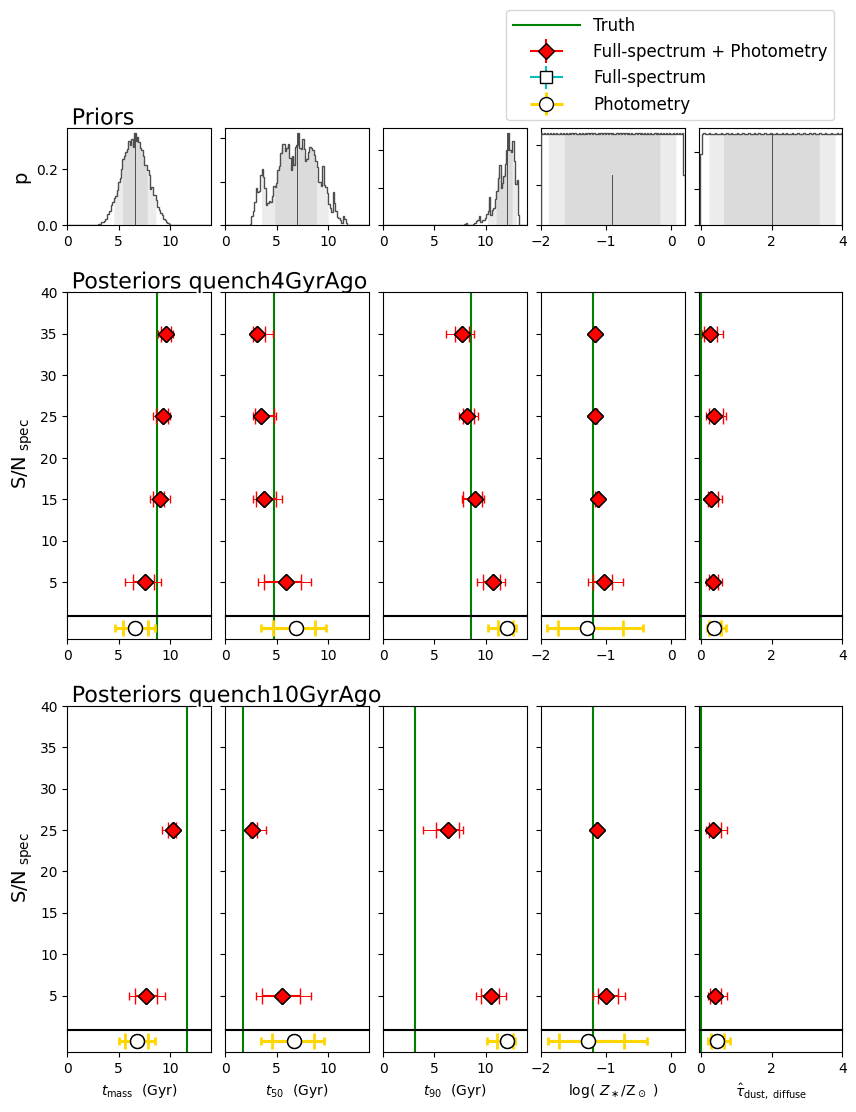

In [8]:
vfits = ['quench4GyrAgo','quench10GyrAgo']

Nvfits = len(vfits)
Npars = len(showpars)
quantiles = [0.05,0.16,0.5,0.84,0.95]

color_truth = 'g'

from matplotlib.legend_handler import HandlerErrorbar
import matplotlib.patheffects as fx

ann_params = dict( xy=(0,0), xycoords='axes fraction', ha='left', va='bottom', xytext=(0.03,1), fontsize=16, zorder=20)

if True: # figure tweaks
    
    hratios = [0.3,0.2]+np.tile( [1,0.07,0.2], Nvfits)[:-1].tolist() 
    Nrows = 2+3*Nvfits - 1
    fig, axes = plt.subplots(Nrows,Npars,figsize=(10,2+5*Nvfits), \
                             gridspec_kw={'height_ratios':hratios}, sharex=False, sharey=False )
    
    axes_priors = axes[0,:].flatten().tolist() 
    axes_specs = axes[2::3,:]
    axes_phots = axes[3::3,:]
        
    for ax in axes[1,:].flatten().tolist() :
        ax.axis('off')
    for ax in axes[4::3,:].flatten().tolist() :
        ax.axis('off')
        
    fig.subplots_adjust( wspace=0.1, hspace=0.01 )
    
if True: # priors
    
    text = axes_priors[0].annotate('Priors', **ann_params )
    text.set_path_effects([ fx.Stroke(linewidth=3, foreground='1.0'), fx.Normal() ])

    for ii in range(Npars):
        par = showpars[ii]
        ax_prior = axes_priors[ii]
        bin_range = showpar_bounds[ii]

        bins = np.linspace( bin_range[0], bin_range[1], 100 )
        n, b,_ = ax_prior.hist( prior_draws[par], bins=bins, histtype='step', 
                                color=color_prior, orientation='vertical', density=True, zorder=3 )
        nl = np.zeros_like(n)
        b=b[:-1]

        qs = np.quantile( prior_draws[par], q=quantiles )
        sel = (qs[0]<b)&(b<qs[-1])
        ax_prior.fill_between( b[sel], nl[sel], n[sel], color=color_prior, lw=0, alpha=0.1, zorder=0  )

        sel = (qs[1]<b)&(b<qs[-2])
        ax_prior.fill_between( b[sel], nl[sel], n[sel], color=color_prior, lw=0, alpha=0.1, zorder=1  )

        sel = np.argmin(np.abs( n - qs[2] ))
        ax_prior.plot( [qs[2],qs[2]],[0,n[sel]], color=color_prior, lw=0.7, zorder=2 )

for ivfit,vfit in enumerate( vfits ):
    axes_spec = axes_specs[ivfit,:]
    axes_phot = axes_phots[ivfit,:]
    
    fits_v = fits[vfit]
    
    text = axes_spec[0].annotate('Posteriors {}'.format(vfit),  **ann_params )
    text.set_path_effects([ fx.Stroke(linewidth=3, foreground='1.0'), fx.Normal() ])
    
    if True: # truths
        for ii,par in enumerate(showpars):
            for axes_  in [ axes_spec[ii], axes_phot[ii] ]:
                axes_.axvline( truths[vfit][par], color=color_truth, zorder=-1 )    
    
    if True: # phot 

        for ii in range(Npars):
            par = showpars[ii]
            ax_phot = axes_phot[ii]

            qs = np.quantile( fits_v['phot']['posts'][par], q=quantiles )

            y_snr = 0
            ax_phot.set_ylim(-1.2,1.2)
            xerr1 = [[qs[2]-qs[0]],[qs[-1]-qs[2]]]
            xerr2 = [[qs[2]-qs[1]],[qs[-2]-qs[2]]]

            ax_phot.errorbar( qs[2], y_snr, yerr=0, xerr=xerr1, zorder=1, capsize=3, **plot_params['phot']  )
            ax_phot.errorbar( qs[2], y_snr, yerr=0, xerr=xerr2, zorder=1, capsize=6, **plot_params['phot']  )

    if True: # both+specs 
        for i,key in enumerate(['both','spec']):
            for snr_key in fits_v[key].keys(): 
                if not snr_key.startswith('snr'): continue
                if fits_v[key][snr_key] is None: continue

                snr = fits_v[key][snr_key]['snr']
                qs_snr_obs =  np.quantile( snr, q=[0.16,0.5,0.84] )
                if i>0:  dqs_snr_obs = 0
                else:    dqs_snr_obs = np.diff( qs_snr_obs ).reshape(2,-1)
                y_snr = qs_snr_obs[1] - i*0.1*qs_snr_obs[1]

                for ii,par in enumerate(showpars):
    #                 if (par in ['dust2']) and (key in ['spec']): continue

                    ax_spec = axes_spec[ii]

                    qs = np.quantile( fits_v[key][snr_key]['posts'][par], q=quantiles )
                    xerr1 = [[qs[2]-qs[0]],[qs[-1]-qs[2]]]
                    xerr2 = [[qs[2]-qs[1]],[qs[-2]-qs[2]]]

                    ax_spec.errorbar( qs[2], y_snr, yerr=dqs_snr_obs, xerr=xerr1, zorder=1, capsize=3, lw=0.7, 
                                  **plot_params[key]  )
                    ax_spec.errorbar( qs[2], y_snr, yerr=None,        xerr=xerr2, zorder=1, capsize=6, 
                                  **plot_params[key]  )
                
if True: # legend 
    
    ax = axes[0,-1]
    xlim,ylim = ax.get_xlim(), ax.get_ylim()
    
    xys = [ [-1],[-1],[15],[1] ]
    h1 = ax.errorbar( *xys, **plot_params['both'], label='Full-spectrum + Photometry')
    h2 = ax.errorbar( *xys, **plot_params['spec'], label='Full-spectrum')
    h3 = ax.errorbar( *xys, **plot_params['phot'], label='Photometry')
    ax.plot( [], color=color_truth, label='Truth')
    
    handler_map={ type(h1): HandlerErrorbar(xerr_size=1, yerr_size=0.7),
                  type(h2): HandlerErrorbar(xerr_size=1, yerr_size=0.7),
                  type(h3): HandlerErrorbar(xerr_size=1, yerr_size=0.7),
                }
    
    ax.legend(loc=4, handlelength=4, fontsize=12, bbox_to_anchor=[1,1.],
              handler_map=handler_map,  # adjust xerr_size to suit the plot
             )    
    
    ax.set_xlim( xlim ) 
    ax.set_ylim( ylim )
        
if True: # tweaks
    
    for ii in range(Npars):
        for ax in axes[:,ii]:
            ax.set_xlim( showpar_bounds[ii] )
        for ax in axes_specs[:,ii]:
            ax.set_ylim( 1,40 )
        for ax in axes_phots[:,ii]:
            ax.set_ylim( -1,1 )
            ax.set_yticks( [] )
        
        axes[-1,ii].set_xlabel( showpar_labels[ii] ) 

    [ ax.set_yticklabels([]) for ax in axes[:,1:].flatten() ]
    [ ax.set_xticklabels([]) for ax in axes_specs.flatten() ]
    
    [ ax.set_ylabel(r"S/N$_\mathrm{~spec}$", fontsize=14 )  for ax in axes_specs[:,0] ]      
    axes_priors[0].set_ylabel("p", fontsize=14 )        

plt.savefig( "figures/like_figB4_with_mock_data.pdf", bbox_inches='tight' )
plt.show()

The calibaration of the posteriors (i.e., how well they match the truth) depends on
- S/N of the observations (in this case the S/N of the spectrscopy is varied)
- the true values. If the prior is close to the truth, then you can get to the right answer without high S/N. This is entirely informed by the prior though!